In [1]:
import curated, rawdata, primary 
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
DB_PATH = '/home/naga/FintelligenceData/MetaTrader_M1.db'
petr3_raw = rawdata.RawData('PETR3',DB_PATH)
parameters = {'ModelParameters':{'MA':[500,1000]}, 'OperationParameters':{'SL': 0.01, 'TP': 0.08, 'IH': 3}}
model = primary.PrimaryModel(petr3_raw,'crossing-MA',parameters)

In [2]:
sample_data = petr3_raw.daily_bars()

In [3]:
sample_data['Min'] = sample_data[(sample_data['Close'].shift(1)>sample_data['Close'])&(sample_data['Close'].shift(-1)>sample_data['Close'])]['Close']
sample_data['Max'] = sample_data[(sample_data['Close'].shift(1)<sample_data['Close'])&(sample_data['Close'].shift(-1)<sample_data['Close'])]['Close']

In [4]:
sample_data

,Open,High,Low,Close,TickVol,Volume,Min,Max
Date,,,,,,,,
2015-12-01,9.04,9.25,8.91,8.94,33945,13644400,NaN,NaN
2015-12-02,8.97,9.16,8.80,9.16,28585,18229600,NaN,NaN
2015-12-03,9.61,9.96,9.30,9.48,34751,25290200,NaN,9.48
2015-12-04,9.43,9.67,8.75,8.83,40188,21870500,NaN,NaN
2015-12-07,8.91,8.97,8.34,8.36,29432,15058900,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-11-24,26.03,27.12,25.99,26.84,58456,23024600,NaN,26.84
2020-11-25,26.71,27.00,26.19,26.66,33118,15680800,NaN,NaN
2020-11-26,26.41,26.43,25.96,26.25,20033,11803100,NaN,NaN


<AxesSubplot:xlabel='Date'>

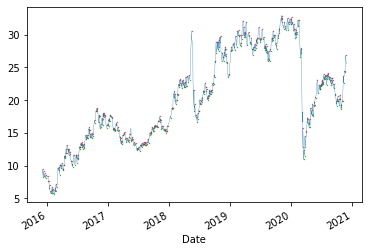

In [5]:
plt.scatter(sample_data.index, sample_data['Min'], c='g', s = 0.1)
plt.scatter(sample_data.index, sample_data['Max'], c='r', s = 0.1)
sample_data.Close.plot(linewidth = 0.3)

In [6]:
sample_data[sample_data['Max']>=0].index

DatetimeIndex(['2015-12-03', '2015-12-09', '2015-12-15', '2015-12-23',
               '2016-01-04', '2016-01-08', '2016-01-14', '2016-01-21',
               '2016-01-27', '2016-01-29',
               ...
               '2020-10-05', '2020-10-08', '2020-10-13', '2020-10-20',
               '2020-10-22', '2020-10-29', '2020-11-05', '2020-11-10',
               '2020-11-19', '2020-11-24'],
              dtype='datetime64[ns]', name='Date', length=313, freq=None)

In [7]:
sample_data[sample_data['Min']>=0].index

DatetimeIndex(['2015-12-08', '2015-12-14', '2015-12-21', '2016-01-07',
               '2016-01-13', '2016-01-20', '2016-01-26', '2016-01-28',
               '2016-02-02', '2016-02-11',
               ...
               '2020-10-02', '2020-10-07', '2020-10-09', '2020-10-16',
               '2020-10-21', '2020-10-28', '2020-10-30', '2020-11-06',
               '2020-11-12', '2020-11-20'],
              dtype='datetime64[ns]', name='Date', length=312, freq=None)

In [8]:
all_events = (sample_data[sample_data['Max']>=0].index).append(sample_data[sample_data['Min']>=0].index).sort_values()

In [9]:
chunk_endpoints = list(zip(all_events.date,all_events[1:].date))

In [158]:
chunk_df = sample_data.loc[chunk_endpoints[4][0]:chunk_endpoints[4][1]]

In [159]:
chunk_df

,Open,High,Low,Close,TickVol,Volume,Min,Max
Date,,,,,,,,
2015-12-15,8.60,8.84,8.59,8.80,17052,8228600,NaN,8.8
2015-12-16,8.69,8.79,8.45,8.66,21785,9712500,NaN,NaN
2015-12-17,8.90,9.05,8.53,8.53,20387,11420300,NaN,NaN
2015-12-18,8.23,8.55,8.23,8.38,23470,16262400,NaN,NaN
2015-12-21,8.39,8.46,7.91,8.04,19704,10087400,8.04,NaN


In [160]:
if chunk_df.iloc[0]['Max']!= np.nan:
    side = -1
else:
    side = 1


In [161]:
side

-1

In [165]:
chunk_df['returns'] = (chunk_df['Close']/ chunk_df['Close'].shift(1) - 1)

In [166]:
chunk_df['CUSUM'] = 0

In [167]:
chunk_df

,Open,High,Low,Close,TickVol,Volume,Min,Max,returns,CUSUM
Date,,,,,,,,,,
2015-12-15,8.60,8.84,8.59,8.80,17052,8228600,NaN,8.8,NaN,0
2015-12-16,8.69,8.79,8.45,8.66,21785,9712500,NaN,NaN,-0.015909,0
2015-12-17,8.90,9.05,8.53,8.53,20387,11420300,NaN,NaN,-0.015012,0
2015-12-18,8.23,8.55,8.23,8.38,23470,16262400,NaN,NaN,-0.017585,0
2015-12-21,8.39,8.46,7.91,8.04,19704,10087400,8.04,NaN,-0.040573,0


In [172]:
for i in range(1,len(chunk_df['CUSUM'].values)):
    chunk_df['CUSUM'].iloc[i] = - max(-(chunk_df['CUSUM'].iloc[i-1] + chunk_df['returns'].iloc[i]),0)

In [1]:
chunk_df

NameError: name 'chunk_df' is not defined

In [176]:
h = 0.03
occurances = chunk_df[chunk_df['CUSUM']<-h]

In [189]:
if not occurances.empty:
    event = [occurances.index[0],side]

In [190]:
event

[Timestamp('2015-12-17 00:00:00'), -1]